### Esercitazione 13 - Momentum
#### Argomenti

* indicatore Momentum
* implementazione di una semplice strategia basata sul Momentum

L'indicatore Momentum indica la velocità delle variazioni di prezzo in uno strumento finanziario.
Evidenzia il tasso di variazione del movimento dei prezzi in un periodo di tempo per aiutare
gli investitori a determinare la forza di una trend.
Il momentum viene utilizzato dagli investitori per negoziare azioni in un trend rialzista
andando long (o acquistando azioni) e andando short (o vendendo azioni) in un trend ribassista.
Poiché lo slancio può essere piuttosto potente e indicare una forte tendenza, gli investitori
devono riconoscere quando stanno investendo con o contro lo slancio di un'azione o del
mercato in generale.

Si può fare un'analogia con un mezzo di locomozione: accelera lentamente quando inizia a
muoversi, ma durante la corsa smette di accelerare: si muove ma a una velocità maggiore
perché tutto lo slancio accumulato dall'accelerazione lo spinge in avanti. Alla fine della
corsa, decelera mentre rallenta.

Nei mercati, alcuni investitori potrebbero entrare e acquistare un titolo in anticipo
mentre il prezzo inizia ad accelerare al rialzo, ma una volta che è chiaro ai partecipanti
al mercato che il titolo ha un potenziale al rialzo, il prezzo decolla.
Per chi usa l'indicatore Momentum, la parte più redditizia della corsa è quando i prezzi
si muovono ad alta velocità. Una volta realizzati i ricavi e gli utili, il mercato di
solito adegua le proprie aspettative e il prezzo ritraccia o torna indietro per riflettere
la performance finanziaria dell'azienda.

E' calcolato con la seguente formula:

Momentum = P - Px

dove:
P = ultmo prezzo conosciuto
Px = prezzo di chiusura all'x-ma candela precedente

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('USDCHF', mt5.TIMEFRAME_D1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [3]:
timeperiod = 7
candles['mom'] = talib.MOM(candles['close'], timeperiod=timeperiod)

ema_1 = 7
ema_2 = 21

str_mom_1 = 'mom_' + str(ema_1)
str_mom_2 = 'mom_' + str(ema_2)
candles[str_mom_1] = talib.EMA(candles['mom'], timeperiod=ema_1)
candles[str_mom_2] = talib.EMA(candles['mom'], timeperiod=ema_2)

candles = candles[27:]

candles.head()

,open,high,low,close,tick_volume,spread,real_volume,mom,mom_7,mom_21
time,,,,,,,,,,
2021-06-03,0.89773,0.90514,0.89759,0.90342,47278,10,0,0.00589,0.001593,-0.002503
2021-06-04,0.90325,0.90532,0.89814,0.89900,52953,10,0,0.00222,0.001750,-0.002074
2021-06-06,0.89889,0.89912,0.89822,0.89889,33,37,0,-0.00083,0.001105,-0.001961
2021-06-07,0.89885,0.90097,0.89657,0.89716,41204,10,0,-0.00182,0.000374,-0.001948
2021-06-08,0.89722,0.89889,0.89512,0.89654,47190,10,0,-0.00205,-0.000232,-0.001957


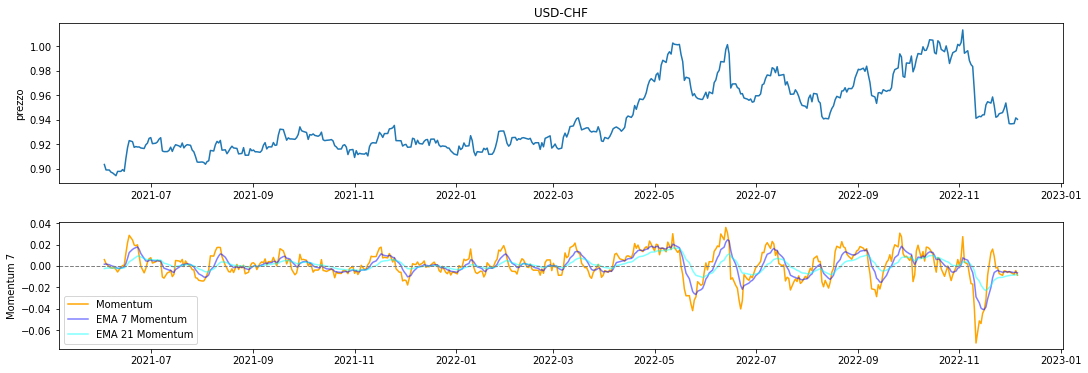

In [4]:
plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(candles['close'])
ax1.set_title('USD-CHF')
ax1.set_ylabel('prezzo')

ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax2.plot(candles['mom'], color = 'orange', label='Momentum')
ax2.plot(candles[str_mom_1], color = 'blue', label='EMA ' + str(ema_1) + ' Momentum', alpha=0.5)
ax2.plot(candles[str_mom_2], color = 'aqua', label='EMA ' + str(ema_2) + ' Momentum', alpha=0.5)
ax2.set_ylabel('Momentum ' + str(timeperiod))
ax2.axhline(0, linestyle = '--', linewidth = 1, color = 'gray')
ax2.legend()

plt.show()

In [7]:
# Strategia:
# apriamo una posizione quando l'indicatore Momentum attraversa la banda centrale (zero):
# long se abbiamo valori della media mobile esponenziale veloce del Momentum più alti
# di quelli della ema lenta; short nel caso opposto.
# Chiudiamo la posizione aperta quando la differenza tra le medie mobili esponenziali scende
# al di sotto del valore pari al delta tra le ema iniziali oppure se l'indicatore momentum
# passa sopra/sotto lo zero tra la candela attuale e la precedente

operazioni = []
mom = 1 if candles.iloc[0].mom > 0 else -1
i = 1
posizione = 0
delta_ema = 0.

while i < len(candles):
    c = candles.iloc[i]
    ts = c.name
    c_1 = candles.iloc[i - 1]

    if posizione == 0:
        if c.mom > 0 and c_1.mom < 0:
            if c[str_mom_1] > c[str_mom_2]:
                posizione = 1
                operazioni.append([ts, np.nan, posizione, c.close, np.nan])
                delta_ema = (c[str_mom_1] - c[str_mom_2]) / ema_2
        if c.mom < 0 and c_1.mom > 0:
            if c[str_mom_1] < c[str_mom_2]:
                posizione = -1
                operazioni.append([ts, np.nan, posizione, c.close, np.nan])
                delta_ema = (c[str_mom_2] - c[str_mom_1]) / ema_2
    else:
        new_delta_ema = abs(c[str_mom_1] - c[str_mom_2]) / ema_2
        if new_delta_ema < delta_ema or (c.mom > 0 != c_1.mom > 0):
            operazioni[-1][1] = c.name
            operazioni[-1][4] = c.close
            posizione = 0
    i += 1

if np.isnan(operazioni[-1][-1]):
    operazioni[-1][1] = c.name
    operazioni[-1][4] = c.close

performance = 0.
for op in operazioni:
    performance += (op[4] - op[3]) * op[2]

print(len(operazioni), 'operazioni')
print('ritorno:', performance)

30 operazioni
ritorno: 0.05074999999999974


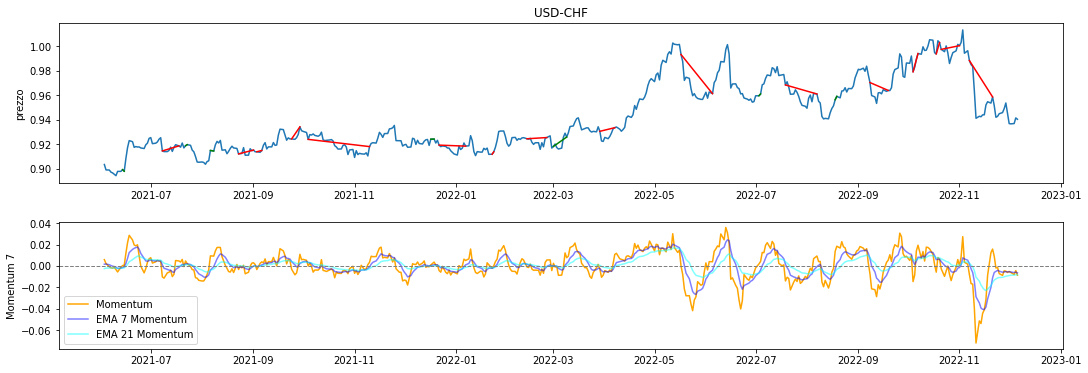

In [6]:
# visualizzazione delle posizioni assunte nel mercato tramite
# l'applicazine della strategia nella cella precedente

plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(candles['close'])
ax1.set_title('USD-CHF')
ax1.set_ylabel('prezzo')

for op in operazioni:
    if op[2] == 1:
        ax1.plot([op[0], op[1]], [op[3], op[4]], color='green')
    else:
        ax1.plot([op[0], op[1]], [op[3], op[4]], color='red')

ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax2.plot(candles['mom'], color = 'orange', label='Momentum')
ax2.plot(candles[str_mom_1], color = 'blue', label='EMA ' + str(ema_1) + ' Momentum', alpha=0.5)
ax2.plot(candles[str_mom_2], color = 'aqua', label='EMA ' + str(ema_2) + ' Momentum', alpha=0.5)
ax2.set_ylabel('Momentum ' + str(timeperiod))
ax2.axhline(0, linestyle = '--', linewidth = 1, color = 'gray')
ax2.legend()

plt.show()

**Errata corrige**    
Rispetto al video che accompagna questo notebook, nella penultima cella, il confronto per chiudere la posizione attuale non era corretto ed è stato modificato aggiungendo la divisione per ``ema_2`` anche nel calcolo di ``new_delta_ema``.